## Fetching Data from NBA API

In [21]:
from nba_api.stats.endpoints import playergamelog
import pandas as pd

player_id = 201939  # Steph Curry's player ID
season = '2024-25'

game_log = playergamelog.PlayerGameLog(player_id=player_id, season=season)
df = game_log.get_data_frames()[0]

# Add home/away status as a binary feature
df['Home'] = df['MATCHUP'].apply(lambda x: 1 if 'vs.' in x else 0)

# Select relevant features
features = ['MIN', 'FGM', 'FTM', 'REB', 'AST', 'STL', 'BLK', 'Home']
target = 'PTS'

# Drop rows with missing values for the selected features and target
df.dropna(subset=features + [target], inplace=True)

# Save to CSV
df.to_csv('steph_curry_game_stats_home_binary.csv', index=False)
print("CSV file saved successfully!")


CSV file saved successfully!


## Training Model and Evaluation

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Load the CSV data
data = pd.read_csv('steph_curry_game_stats_home_binary.csv')

# Define features and target variable
X = data[features]
y = data[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)

# Print the actual and predicted values
print("Actual values in test set:", y_test.values)
print("Predicted values:", predictions)


Mean Squared Error: 16.457835026652212
Number of training samples: 8
Number of testing samples: 2
Actual values in test set: [20 13]
Predicted values: [17.39258999  7.88951244]


## Visualisation

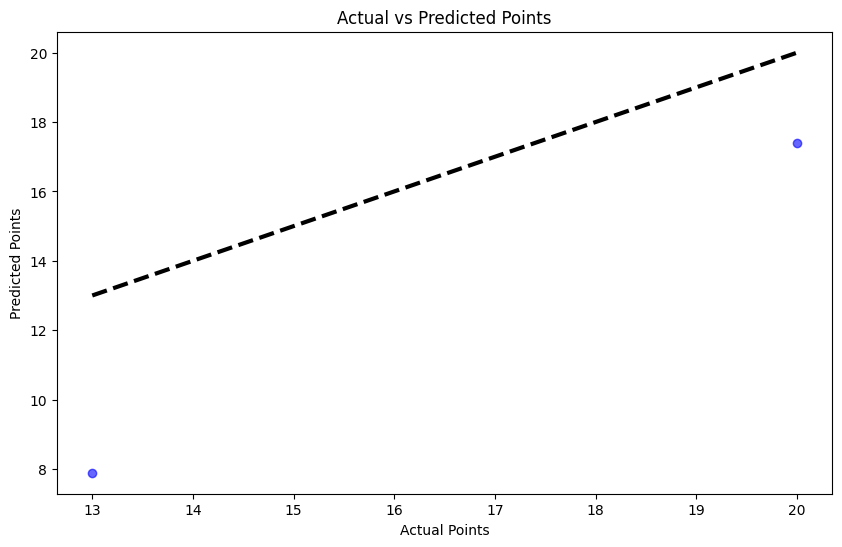

In [26]:
import matplotlib.pyplot as plt
# Actual vs Predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.6, color='b')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
plt.xlabel('Actual Points')
plt.ylabel('Predicted Points')
plt.title('Actual vs Predicted Points')
plt.show()


## Prediction for Future Games

In [23]:
# Example mock data for an upcoming game with the Home feature
mock_data = {
    'MIN': [35],
    'FGM': [10],
    'FTM': [5],
    'REB': [6],
    'AST': [7],
    'STL': [2],
    'BLK': [1],
    'Home': [1]  # Example: playing at home
}
mock_df = pd.DataFrame(mock_data)

# Predict points for the next game
prediction = model.predict(mock_df)
print("Predicted Points for the next game:", prediction[0])


Predicted Points for the next game: 31.688410236002568
